# 🏴‍☠️ Pain Pirate Analysis - Pipeline Completa PyTorch

Pipeline end-to-end con **tutte le 7 ADVICE del professore integrate nel codice**.

## Dataset
- **pirate_pain_train.csv**: 105,760 righe = 661 samples × 160 timesteps
- **pirate_pain_train_labels.csv**: 661 labels (no_pain, low_pain, high_pain)
- **pirate_pain_test.csv**: 1,324 test samples × 160 timesteps
- **Features**: 38 (4 pain_survey + 3 categorical + 31 joints)
- **Classe dominante**: no_pain (511) - dataset **sbilanciato**!

## ADVICE Integrate
1. ✅ **11/11 - Autocorrelazione**: Window size basata sui dati
2. ✅ **12/11 - Time Features**: Encoding ciclico temporale
3. ✅ **13/11 - Conv1D+LSTM**: Architettura ibrida
4. ✅ **10/11 - Gradient Clipping**: Stabilizza training
5. ✅ **09/11 - Label Smoothing**: Loss con smoothing
6. ✅ **08/11 - Class Weighting**: Gestisce sbilanciamento
7. ✅ **07/11 - Embeddings**: Features categoriche


In [1]:
# Core libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Stats and ML
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

# Set seeds
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f'PyTorch: {torch.__version__}')
print(f'Device: {device}')
print('✅ Environment ready!')

c:\Users\jjarb\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch: 2.9.1+cpu
Device: cpu
✅ Environment ready!


## 1. Caricamento Dati

In [2]:
# Load dataset
X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

print('📊 Dataset Shape:')
print(f'  Features: {X_train.shape}')
print(f'  Labels: {y_train.shape}')
print(f'  Samples: {X_train["sample_index"].nunique()}')
print(f'  Timesteps/sample: {X_train.groupby("sample_index").size().iloc[0]}')

# Feature groups
pain_survey_cols = [c for c in X_train.columns if 'pain_survey' in c]
categorical_cols = ['n_legs', 'n_hands', 'n_eyes']
joint_cols = [c for c in X_train.columns if 'joint_' in c]

print(f'\n📋 Features: {len(pain_survey_cols)} pain_survey + {len(categorical_cols)} categorical + {len(joint_cols)} joints')

# ADVICE 08/11: Check class imbalance
print(f'\n🏷️ Labels (IMBALANCED - need class weighting):')
for label, count in y_train['label'].value_counts().items():
    print(f'  {label}: {count} ({100*count/len(y_train):.1f}%)')

📊 Dataset Shape:
  Features: (105760, 40)
  Labels: (661, 2)
  Samples: 661
  Timesteps/sample: 160

📋 Features: 4 pain_survey + 3 categorical + 31 joints

🏷️ Labels (IMBALANCED - need class weighting):
  no_pain: 511 (77.3%)
  low_pain: 94 (14.2%)
  high_pain: 56 (8.5%)


## 2. ADVICE 11/11: Determinare WINDOW_SIZE

*"Its own echo, the series sings."*

Usiamo autocorrelazione per scegliere window size basata sui dati.

In [3]:
# ADVICE 11/11: Analyze autocorrelation to determine optimal window
print('🔍 Analyzing autocorrelation...')
samples_analyze = X_train['sample_index'].unique()[:10]
key_features = joint_cols[:6]

optimal_lags = {}
for feature in key_features:
    sample_lags = []
    for sid in samples_analyze:
        data = X_train[X_train['sample_index']==sid][feature].values
        if len(data) >= 50:
            max_lags = min(len(data)//2-1, 80)
            acf_vals = acf(data, nlags=max_lags)
            sig_bound = 1.96/np.sqrt(len(data))
            for lag in range(1, len(acf_vals)):
                if abs(acf_vals[lag]) < sig_bound:
                    sample_lags.append(lag)
                    break
            else:
                sample_lags.append(max_lags)
    if sample_lags:
        optimal_lags[feature] = int(np.median(sample_lags))

if optimal_lags:
    suggested = int(np.median(list(optimal_lags.values())))
    WINDOW_SIZE = max(min(suggested, 100), 40)
else:
    WINDOW_SIZE = 60

WINDOW_STRIDE = WINDOW_SIZE // 2

print(f'✅ WINDOW_SIZE from autocorrelation: {WINDOW_SIZE}')
print(f'   STRIDE: {WINDOW_STRIDE}')
print(f'💡 ADVICE 11/11: Data-driven window size!')

🔍 Analyzing autocorrelation...
✅ WINDOW_SIZE from autocorrelation: 40
   STRIDE: 20
💡 ADVICE 11/11: Data-driven window size!


## 3. Preprocessing con ADVICE 07/11 e 12/11

**ADVICE 07/11**: Map categorical per embeddings  
**ADVICE 12/11**: Aggiungi time features ciclici

In [4]:
# ADVICE 07/11: Map categorical features
cat_map = {
    'n_legs': {'two': 0, 'one+peg_leg': 1},
    'n_hands': {'two': 0, 'one+hook_hand': 1},
    'n_eyes': {'two': 0, 'one+eye_patch': 1}
}

X_proc = X_train.copy()
for col, mapping in cat_map.items():
    X_proc[col] = X_proc[col].map(mapping).fillna(0).astype(int)

# ADVICE 12/11: Add cyclical time features
max_time = X_proc['time'].max()
X_proc['time_sin'] = np.sin(2*np.pi*X_proc['time']/max_time)
X_proc['time_cos'] = np.cos(2*np.pi*X_proc['time']/max_time)
X_proc['time_norm'] = X_proc['time']/max_time

print('✅ Preprocessing done:')
print('   - ADVICE 07/11: Categorical mapped')
print('   - ADVICE 12/11: Time features (sin, cos, norm) added')
print(f'   Shape: {X_proc.shape}')

✅ Preprocessing done:
   - ADVICE 07/11: Categorical mapped
   - ADVICE 12/11: Time features (sin, cos, norm) added
   Shape: (105760, 43)


## 4. Creazione Finestre

In [5]:
# Create sliding windows
def create_windows(df, sample_idx, window_size, stride):
    sample = df[df['sample_index']==sample_idx].sort_values('time')
    feat_cols = [c for c in sample.columns if c not in ['sample_index','time']]
    features = sample[feat_cols].values

    windows = []
    for start in range(0, max(1, len(features)-window_size+1), stride):
        end = min(start+window_size, len(features))
        win = features[start:end]
        if len(win) < window_size:
            pad = np.zeros((window_size-len(win), win.shape[1]))
            win = np.vstack([win, pad])
        windows.append(win)
    return windows

print('🔄 Creating windows...')
all_windows = []
all_labels = []

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train['label'])

for sid, label in zip(y_train['sample_index'], y_encoded):
    wins = create_windows(X_proc, sid, WINDOW_SIZE, WINDOW_STRIDE)
    all_windows.extend(wins)
    all_labels.extend([label]*len(wins))

X_windows = np.array(all_windows, dtype=np.float32)
y_windows = np.array(all_labels, dtype=np.int64)

print(f'✅ Windows: {X_windows.shape}')
print(f'   Labels: {y_windows.shape}')

🔄 Creating windows...
✅ Windows: (4627, 40, 41)
   Labels: (4627,)


In [6]:
# Split and normalize
X_tr, X_val, y_tr, y_val = train_test_split(
    X_windows, y_windows, test_size=0.2, random_state=SEED, stratify=y_windows
)

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr.reshape(-1, X_tr.shape[-1])).reshape(X_tr.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

print(f'📊 Split: Train {X_tr.shape}, Val {X_val.shape}')

# ADVICE 08/11: Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
class_weights_tensor = torch.FloatTensor(class_weights_array).to(device)

print(f'\n⚖️ ADVICE 08/11 - Class Weights:')
for i, w in enumerate(class_weights_array):
    print(f'   {label_encoder.classes_[i]}: {w:.3f}')

# Create DataLoaders
train_dataset = TensorDataset(
    torch.FloatTensor(X_tr),
    torch.LongTensor(y_tr)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_val),
    torch.LongTensor(y_val)
)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'\n✅ DataLoaders ready (batch_size={BATCH_SIZE})')

📊 Split: Train (3701, 40, 41), Val (926, 40, 41)

⚖️ ADVICE 08/11 - Class Weights:
   high_pain: 3.929
   low_pain: 2.345
   no_pain: 0.431

✅ DataLoaders ready (batch_size=16)


## 5. ADVICE 13/11: Conv1D + LSTM

*"A pattern in time, like a pattern in space it is."*

In [7]:
# ADVICE 13/11: Build Conv1D + LSTM model
class ConvLSTMClassifier(nn.Module):
    """Hybrid CNN-LSTM for time series classification."""

    def __init__(self, input_size, num_classes,
                 conv_filters=[64, 64], lstm_units=128, dropout=0.5):
        super().__init__()

        # Conv1D layers for local pattern extraction
        self.conv_layers = nn.ModuleList()
        in_channels = input_size

        for filters in conv_filters:
            self.conv_layers.append(nn.Sequential(
                nn.Conv1d(in_channels, filters, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm1d(filters),
                nn.MaxPool1d(2),
                nn.Dropout(dropout)
            ))
            in_channels = filters

        # LSTM for temporal dependencies
        self.lstm = nn.LSTM(
            input_size=conv_filters[-1],
            hidden_size=lstm_units,
            batch_first=True,
            bidirectional=True
        )

        # Classification head
        self.fc1 = nn.Linear(lstm_units * 2, 64)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, features)
        x = x.transpose(1, 2)  # -> (batch, features, seq_len) for Conv1D

        # Apply Conv1D layers
        for conv in self.conv_layers:
            x = conv(x)

        # Back to (batch, seq_len, features) for LSTM
        x = x.transpose(1, 2)

        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = torch.cat([h_n[0], h_n[1]], dim=1)  # Concatenate bidirectional

        # Classification
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# Initialize model
n_features = X_tr.shape[2]
n_classes = len(label_encoder.classes_)

model = ConvLSTMClassifier(
    input_size=n_features,
    num_classes=n_classes,
    conv_filters=[32, 32],
    lstm_units=64
).to(device)

print('✅ ADVICE 13/11: Conv1D + LSTM created')
print(f'   Input: ({WINDOW_SIZE}, {n_features})')
print(f'   Output: {n_classes} classes')
print(f'   Parameters: {sum(p.numel() for p in model.parameters()):,}')

✅ ADVICE 13/11: Conv1D + LSTM created
   Input: (40, 41)
   Output: 3 classes
   Parameters: 65,827


## 6. ADVICE 09/11 + 08/11: Loss Function

**ADVICE 09/11**: Label smoothing  
**ADVICE 08/11**: Class weighting

In [8]:
# ADVICE 09/11: Label Smoothing + ADVICE 08/11: Class Weighting
class WeightedLabelSmoothingCE(nn.Module):
    """Combines label smoothing (ADVICE 09/11) and class weighting (ADVICE 08/11)."""

    def __init__(self, class_weights, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
        self.register_buffer('class_weights', class_weights)

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (pred.size(-1) - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)

        # Apply class weights
        weights = self.class_weights[target]
        return torch.mean(weights * torch.sum(-true_dist * pred, dim=-1))

# Initialize loss function
criterion = WeightedLabelSmoothingCE(
    class_weights=class_weights_tensor,
    smoothing=0.1
)

print('✅ Loss function initialized:')
print('   - ADVICE 09/11: Label smoothing (0.1)')
print('   - ADVICE 08/11: Class weights integrated')

✅ Loss function initialized:
   - ADVICE 09/11: Label smoothing (0.1)
   - ADVICE 08/11: Class weights integrated


## 7. Training con ADVICE 10/11: Gradient Clipping

*"A step too great, from the precipice fall it makes you."*

In [9]:
# ADVICE 10/11: Training with gradient clipping
def train_epoch(model, loader, criterion, optimizer, device, max_grad_norm=1.0):
    """Train one epoch with gradient clipping."""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()

        # ADVICE 10/11: Gradient clipping
        if max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, f1

def eval_epoch(model, loader, criterion, device):
    """Evaluate one epoch."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    f1 = f1_score(all_labels, all_preds, average='macro')
    return avg_loss, f1, all_preds, all_labels

print('✅ Training functions defined with ADVICE 10/11 (gradient clipping)')

✅ Training functions defined with ADVICE 10/11 (gradient clipping)


### Configurazioni per la Grid Search

Definisci qui le combinazioni di iperparametri da testare prima di eseguire il training finale.


### Grid Search sugli iperparametri

Eseguiamo un ciclo sulle configurazioni definite, valutando l'F1 macro su validation per selezionare la migliore.

In [10]:
import optuna

# ============================
# 1) Objective per Optuna
# ============================
def objective(trial):

    # --- spazio degli iperparametri (adattalo come vuoi) ---
    conv_filters = trial.suggest_categorical(
        "conv_filters",
        [
            [160, 160],
            [48, 48],
            [64, 64],
            [48, 96],
            [64, 128],
            [64, 32],
            [128, 128],
            [128,64]
        ]
    )
    lstm_units = trial.suggest_categorical("lstm_units", [32,64, 128, 160, 192])

    dropout = trial.suggest_float("dropout", 0.10, 0.40)
    lr = trial.suggest_float("lr", 3e-4, 1e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.15)

    scheduler_factor = trial.suggest_float("scheduler_factor", 0.2, 0.6)
    scheduler_patience = trial.suggest_int("scheduler_patience", 2, 5)

    early_stop_patience = trial.suggest_int("early_stop_patience", 4, 8)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)

    # puoi anche far scegliere a Optuna il numero di epoche di "search"
    epochs_to_run = trial.suggest_int("search_epochs", 15, 50)

    # ============================
    # 2) Modello + training loop
    # ============================
    model_gs = ConvLSTMClassifier(
        input_size=n_features,
        num_classes=n_classes,
        conv_filters=conv_filters,
        lstm_units=lstm_units,
        dropout=dropout
    ).to(device)

    criterion_gs = WeightedLabelSmoothingCE(
        class_weights=class_weights_tensor,
        smoothing=label_smoothing
    )

    optimizer_gs = AdamW(
        model_gs.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    scheduler_gs = ReduceLROnPlateau(
        optimizer_gs,
        mode='max',
        factor=scheduler_factor,
        patience=scheduler_patience
    )

    best_f1_cfg = -np.inf
    patience_counter = 0

    for epoch in range(epochs_to_run):
        train_loss, train_f1 = train_epoch(
            model_gs, train_loader, criterion_gs, optimizer_gs, device, max_grad_norm
        )
        val_loss, val_f1, _, _ = eval_epoch(
            model_gs, val_loader, criterion_gs, device
        )
        scheduler_gs.step(val_f1)

        '''print(
            f"  Trial {trial.number:03d} | "
            f"Epoch {epoch+1:02d}/{epochs_to_run} | "
            f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}",
            end="\r"
        )'''

        # per Optuna: log dello stato intermedio (utile per pruning)
        trial.report(val_f1, epoch)

        # pruning: se il trial va male, lo stoppa prima
        if trial.should_prune():
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            raise optuna.TrialPruned()

        # early stopping "classico"
        if val_f1 > best_f1_cfg:
            best_f1_cfg = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                break

    print()  # newline

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Optuna massimizza questo
    return best_f1_cfg


# ============================
# 3) Lancio dello studio Optuna
# ============================
n_trials = 300  # quante combinazioni vuoi provare

study = optuna.create_study(
    direction="maximize",
    study_name="conv_lstm_opt"
)

study.optimize(objective, n_trials=n_trials)

# ============================
# 4) Risultati e tabella tipo grid_search_df
# ============================
print("\n🏁 Optuna terminato")
print(f"🔝 Best F1 val: {study.best_value:.4f}")
print("🔧 Best params:")
for k, v in study.best_params.items():
    print(f"   {k}: {v}")

# dataframe con tutti i trial, simile al tuo grid_search_df
optuna_df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
optuna_df = optuna_df.sort_values(by="value", ascending=False)
display(optuna_df)


[I 2025-11-16 11:09:57,988] A new study created in memory with name: conv_lstm_opt
[I 2025-11-16 11:12:00,933] Trial 0 finished with value: 0.984681236474159 and parameters: {'conv_filters': [128, 128], 'lstm_units': 128, 'dropout': 0.17257400788843555, 'lr': 0.0005276906133871009, 'weight_decay': 3.3371340882632224e-05, 'label_smoothing': 0.07649812628812919, 'scheduler_factor': 0.24854782635296205, 'scheduler_patience': 2, 'early_stop_patience': 5, 'max_grad_norm': 1.4625048342354405, 'search_epochs': 46}. Best is trial 0 with value: 0.984681236474159.


[I 2025-11-16 11:12:52,833] Trial 1 finished with value: 0.9659279254541125 and parameters: {'conv_filters': [128, 64], 'lstm_units': 64, 'dropout': 0.25114890769418097, 'lr': 0.00034131589988545876, 'weight_decay': 0.0007421112053992067, 'label_smoothing': 0.025112953227777624, 'scheduler_factor': 0.5308837671079392, 'scheduler_patience': 3, 'early_stop_patience': 4, 'max_grad_norm': 1.0979929832909137, 'search_epochs': 17}. Best is trial 0 with value: 0.984681236474159.


[I 2025-11-16 11:14:11,601] Trial 2 finished with value: 0.9662056116581551 and parameters: {'conv_filters': [64, 64], 'lstm_units': 160, 'dropout': 0.2411655230056472, 'lr': 0.0005739947748435918, 'weight_decay': 9.93316639108971e-06, 'label_smoothing': 0.07250278746357448, 'scheduler_factor': 0.25259623438308665, 'scheduler_patience': 3, 'early_stop_patience': 8, 'max_grad_norm': 0.693699854899581, 'search_epochs': 21}. Best is trial 0 with value: 0.984681236474159.


[I 2025-11-16 11:16:49,001] Trial 3 finished with value: 0.9841427420988405 and parameters: {'conv_filters': [48, 96], 'lstm_units': 128, 'dropout': 0.2808520365406593, 'lr': 0.0005142305341249691, 'weight_decay': 2.8096209065498404e-06, 'label_smoothing': 0.020188440443135742, 'scheduler_factor': 0.5973080486029902, 'scheduler_patience': 5, 'early_stop_patience': 7, 'max_grad_norm': 1.254791341052831, 'search_epochs': 47}. Best is trial 0 with value: 0.984681236474159.


[I 2025-11-16 11:18:26,996] Trial 4 finished with value: 0.977643662100553 and parameters: {'conv_filters': [160, 160], 'lstm_units': 64, 'dropout': 0.22430422599001354, 'lr': 0.0007705561099879871, 'weight_decay': 7.247826985588245e-05, 'label_smoothing': 0.06598554869799321, 'scheduler_factor': 0.46091563061626795, 'scheduler_patience': 5, 'early_stop_patience': 8, 'max_grad_norm': 0.6403793971502166, 'search_epochs': 25}. Best is trial 0 with value: 0.984681236474159.


[I 2025-11-16 11:18:30,291] Trial 5 pruned. 
[I 2025-11-16 11:18:32,766] Trial 6 pruned. 
[I 2025-11-16 11:18:50,050] Trial 7 pruned. 
[I 2025-11-16 11:18:52,891] Trial 8 pruned. 
[I 2025-11-16 11:19:21,464] Trial 9 pruned. 
[I 2025-11-16 11:19:25,716] Trial 10 pruned. 
[I 2025-11-16 11:19:29,094] Trial 11 pruned. 
[I 2025-11-16 11:19:32,532] Trial 12 pruned. 
[I 2025-11-16 11:19:36,266] Trial 13 pruned. 
[I 2025-11-16 11:19:38,800] Trial 14 pruned. 
[I 2025-11-16 11:19:43,917] Trial 15 pruned. 
[I 2025-11-16 11:20:00,698] Trial 16 pruned. 
[I 2025-11-16 11:20:03,971] Trial 17 pruned. 
[I 2025-11-16 11:20:07,067] Trial 18 pruned. 
[I 2025-11-16 11:20:21,920] Trial 19 pruned. 
[I 2025-11-16 11:20:24,589] Trial 20 pruned. 
[I 2025-11-16 11:20:52,837] Trial 21 pruned. 
[I 2025-11-16 11:21:12,199] Trial 22 pruned. 
[I 2025-11-16 11:21:22,324] Trial 23 pruned. 
[I 2025-11-16 11:21:47,649] Trial 24 pruned. 
[I 2025-11-16 11:21:51,091] Trial 25 pruned. 
[I 2025-11-16 11:22:04,338] Trial 26 pr

[I 2025-11-16 11:44:00,057] Trial 122 pruned. 
[I 2025-11-16 11:44:20,126] Trial 123 pruned. 
[I 2025-11-16 11:44:37,801] Trial 124 pruned. 
[I 2025-11-16 11:45:31,034] Trial 125 pruned. 
[I 2025-11-16 11:45:47,820] Trial 126 pruned. 
[I 2025-11-16 11:46:04,228] Trial 127 pruned. 
[I 2025-11-16 11:46:24,698] Trial 128 pruned. 
[I 2025-11-16 11:46:45,392] Trial 129 pruned. 
[I 2025-11-16 11:47:02,033] Trial 130 pruned. 
[I 2025-11-16 11:47:23,849] Trial 131 pruned. 
[I 2025-11-16 11:47:28,982] Trial 132 pruned. 
[I 2025-11-16 11:47:45,224] Trial 133 pruned. 
[I 2025-11-16 11:48:01,031] Trial 134 pruned. 
[I 2025-11-16 11:48:14,578] Trial 135 pruned. 
[I 2025-11-16 11:48:32,598] Trial 136 pruned. 
[I 2025-11-16 11:48:35,165] Trial 137 pruned. 
[I 2025-11-16 11:48:38,331] Trial 138 pruned. 
[I 2025-11-16 11:48:54,411] Trial 139 pruned. 
[I 2025-11-16 11:49:03,635] Trial 140 pruned. 
[I 2025-11-16 11:49:15,748] Trial 141 pruned. 
[I 2025-11-16 11:49:48,054] Trial 142 pruned. 
[I 2025-11-16

[I 2025-11-16 11:55:05,279] Trial 148 pruned. 
[I 2025-11-16 11:55:34,391] Trial 149 pruned. 
[I 2025-11-16 11:55:38,503] Trial 150 pruned. 
[I 2025-11-16 11:57:00,538] Trial 151 pruned. 
[I 2025-11-16 11:57:25,658] Trial 152 pruned. 
[I 2025-11-16 11:58:04,472] Trial 153 pruned. 
[I 2025-11-16 11:58:25,062] Trial 154 pruned. 
[I 2025-11-16 11:58:31,630] Trial 155 pruned. 
[I 2025-11-16 11:58:49,497] Trial 156 pruned. 
[I 2025-11-16 11:58:52,677] Trial 157 pruned. 
[I 2025-11-16 11:59:04,189] Trial 158 pruned. 
[I 2025-11-16 11:59:25,703] Trial 159 pruned. 
[I 2025-11-16 11:59:30,506] Trial 160 pruned. 
[I 2025-11-16 11:59:34,750] Trial 161 pruned. 
[I 2025-11-16 11:59:38,967] Trial 162 pruned. 
[I 2025-11-16 11:59:51,971] Trial 163 pruned. 
[I 2025-11-16 12:00:00,681] Trial 164 pruned. 
[I 2025-11-16 12:00:04,910] Trial 165 pruned. 
[I 2025-11-16 12:00:08,968] Trial 166 pruned. 
[I 2025-11-16 12:00:12,621] Trial 167 pruned. 
[I 2025-11-16 12:00:33,695] Trial 168 pruned. 
[I 2025-11-16

[I 2025-11-16 12:06:53,698] Trial 194 pruned. 
[I 2025-11-16 12:06:57,899] Trial 195 pruned. 
[I 2025-11-16 12:07:07,185] Trial 196 pruned. 
[I 2025-11-16 12:07:11,465] Trial 197 pruned. 
[I 2025-11-16 12:07:22,893] Trial 198 pruned. 
[I 2025-11-16 12:07:26,978] Trial 199 pruned. 
[I 2025-11-16 12:07:30,458] Trial 200 pruned. 
[I 2025-11-16 12:07:43,462] Trial 201 pruned. 
[I 2025-11-16 12:07:47,700] Trial 202 pruned. 
[I 2025-11-16 12:07:51,740] Trial 203 pruned. 
[I 2025-11-16 12:09:19,214] Trial 204 finished with value: 0.9777110328759478 and parameters: {'conv_filters': [128, 128], 'lstm_units': 128, 'dropout': 0.1917154181486078, 'lr': 0.0005389097726267925, 'weight_decay': 6.300100191959683e-05, 'label_smoothing': 0.07073557280087428, 'scheduler_factor': 0.25881577373844517, 'scheduler_patience': 3, 'early_stop_patience': 7, 'max_grad_norm': 0.5009085407856145, 'search_epochs': 21}. Best is trial 147 with value: 0.9869851984397977.


[I 2025-11-16 12:09:23,381] Trial 205 pruned. 
[I 2025-11-16 12:09:28,620] Trial 206 pruned. 
[I 2025-11-16 12:09:32,242] Trial 207 pruned. 
[I 2025-11-16 12:09:35,696] Trial 208 pruned. 
[I 2025-11-16 12:09:40,461] Trial 209 pruned. 
[I 2025-11-16 12:09:44,246] Trial 210 pruned. 
[I 2025-11-16 12:09:56,758] Trial 211 pruned. 
[I 2025-11-16 12:10:01,161] Trial 212 pruned. 
[I 2025-11-16 12:10:05,428] Trial 213 pruned. 
[I 2025-11-16 12:10:09,636] Trial 214 pruned. 
[I 2025-11-16 12:10:26,656] Trial 215 pruned. 
[I 2025-11-16 12:10:32,722] Trial 216 pruned. 
[I 2025-11-16 12:10:43,149] Trial 217 pruned. 
[I 2025-11-16 12:10:45,877] Trial 218 pruned. 
[I 2025-11-16 12:10:49,712] Trial 219 pruned. 
[I 2025-11-16 12:10:54,038] Trial 220 pruned. 
[I 2025-11-16 12:10:57,958] Trial 221 pruned. 
[I 2025-11-16 12:11:01,863] Trial 222 pruned. 
[I 2025-11-16 12:11:05,686] Trial 223 pruned. 
[I 2025-11-16 12:11:09,610] Trial 224 pruned. 
[I 2025-11-16 12:11:14,201] Trial 225 pruned. 
[I 2025-11-16


🏁 Optuna terminato
🔝 Best F1 val: 0.9870
🔧 Best params:
   conv_filters: [128, 128]
   lstm_units: 128
   dropout: 0.14348970822082446
   lr: 0.0005062106478411532
   weight_decay: 4.775027710928475e-05
   label_smoothing: 0.07831483298223882
   scheduler_factor: 0.2593154395151444
   scheduler_patience: 3
   early_stop_patience: 7
   max_grad_norm: 0.5929471162934898
   search_epochs: 48


,number,value,params_conv_filters,params_dropout,params_early_stop_patience,params_label_smoothing,params_lr,params_lstm_units,params_max_grad_norm,params_scheduler_factor,params_scheduler_patience,params_search_epochs,params_weight_decay,state
147,147,0.986985,"[128, 128]",0.143490,7,0.078315,0.000506,128,0.592947,0.259315,3,48,0.000048,COMPLETE
0,0,0.984681,"[128, 128]",0.172574,5,0.076498,0.000528,128,1.462505,0.248548,2,46,0.000033,COMPLETE
3,3,0.984143,"[48, 96]",0.280852,7,0.020188,0.000514,128,1.254791,0.597308,5,47,0.000003,COMPLETE
121,121,0.979897,"[128, 128]",0.190450,7,0.083188,0.000801,128,0.501901,0.256194,3,45,0.000082,COMPLETE
204,204,0.977711,"[128, 128]",0.191715,7,0.070736,0.000539,128,0.500909,0.258816,3,21,0.000063,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,76,0.685141,"[48, 96]",0.300593,6,0.062219,0.000604,64,0.726837,0.471645,3,16,0.000302,PRUNED
46,46,0.677743,"[48, 96]",0.322358,4,0.026482,0.000485,32,1.417830,0.423678,2,21,0.000163,PRUNED
42,42,0.674592,"[128, 128]",0.232152,5,0.012003,0.000362,64,1.051719,0.526071,3,18,0.000004,PRUNED
14,14,0.672028,"[48, 96]",0.184779,6,0.002828,0.000449,32,1.347676,0.478376,4,43,0.000027,PRUNED


## 8. Training Loop

In [17]:
from copy import deepcopy # <-- AGGIUNTA CHIAVE PER RISOLVERE L'ERRORE

def train_one_model(seed):
    # Set seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model = ConvLSTMClassifier(
        input_size=n_features,
        num_classes=n_classes,
        conv_filters=conv_filters,
        lstm_units=lstm_units,
        dropout=dropout
    ).to(device)

    criterion = WeightedLabelSmoothingCE(
        class_weights=class_weights_tensor,
        smoothing=label_smoothing
    )

    optimizer = AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )
    
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=scheduler_factor,
        patience=scheduler_patience
    )

    best_f1 = 0.0
    patience_counter = 0
    best_model_state = None # <-- Corretto da best_state a best_model_state
    history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

    for epoch in range(epochs):
        train_loss, train_f1 = train_epoch(
            model, train_loader, criterion, optimizer, device, max_grad_norm
        )
        val_loss, val_f1, _, _ = eval_epoch(
            model, val_loader, criterion, device
        )
        scheduler.step(val_f1)
        
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)

        print(f'Epoch {epoch+1:02d}/{epochs} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}', end='\r')

        if val_f1 > best_f1:
            best_f1 = val_f1
            # Ora 'deepcopy' è definito
            best_model_state = deepcopy(model.state_dict()) # <-- Corretto da best_state
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break
    
    print() # Newline
    return best_model_state, best_f1, history

In [18]:
# =======================================================
# 1. ESTRAI I PARAMETRI DA OPTUNA (Risolve il NameError)
# =======================================================
if "study" not in globals():
    raise RuntimeError("Errore: 'study' non è definito. Esegui prima la cella Optuna (Sezione 9).")

# Estrai i parametri migliori da Optuna
best_params = study.best_params

# Definisci le variabili in minuscolo, come richiesto dalla funzione train_one_model
conv_filters       = best_params["conv_filters"]
lstm_units         = best_params["lstm_units"]
dropout            = best_params["dropout"]
lr                 = best_params["lr"]
weight_decay       = best_params["weight_decay"]
label_smoothing    = best_params["label_smoothing"]
max_grad_norm      = best_params["max_grad_norm"]       # <-- Corretto in minuscolo
epochs             = best_params["search_epochs"]       # <-- Corretto in minuscolo
early_stop_patience = best_params["early_stop_patience"] # <-- Corretto in minuscolo
scheduler_patience = best_params["scheduler_patience"] # <-- Corretto in minuscolo
scheduler_factor   = best_params["scheduler_factor"]   # <-- Corretto in minuscolo

# (n_features, n_classes, class_weights_tensor, device, 
#  train_loader, val_loader dovrebbero essere già globali dalle celle precedenti)

# =======================================================
# 2. ESEGUI IL LOOP DI TRAINING (il tuo codice originale)
# =======================================================
SEEDS = [0, 1, 2, 42, 1337]
models = []
model_f1 = []
histories = []   

for s in SEEDS:
    print(f"\n🔥 Training model with seed {s}")
    # Chiama la funzione (che ora troverà le variabili globali in minuscolo)
    m, f, h = train_one_model(s)   
    models.append(m)
    model_f1.append(f)
    histories.append(h)            

print("F1 dei singoli modelli:", model_f1)


🔥 Training model with seed 0
Epoch 31/48 | Train F1: 0.9975 | Val F1: 0.9821
Early stopping at epoch 31


🔥 Training model with seed 1
Epoch 36/48 | Train F1: 0.9988 | Val F1: 0.9836
Early stopping at epoch 36


🔥 Training model with seed 2
Epoch 27/48 | Train F1: 0.9958 | Val F1: 0.9705
Early stopping at epoch 27


🔥 Training model with seed 42
Epoch 34/48 | Train F1: 0.9961 | Val F1: 0.9798
Early stopping at epoch 34


🔥 Training model with seed 1337
Epoch 36/48 | Train F1: 0.9981 | Val F1: 0.9787
Early stopping at epoch 36

F1 dei singoli modelli: [0.9829358472518065, 0.9860488451683419, 0.9773713944924077, 0.98539688152775, 0.9788699158760775]


In [19]:
single_f1 = np.array(model_f1)
losses = 1 - single_f1
eta = 15.0
weights = np.exp(-eta * losses)
weights /= weights.sum()
print("Pesi EWA:", weights)


Pesi EWA: [0.20217692 0.21184145 0.18598692 0.20977986 0.19021484]


In [22]:
# =======================================================
# 1. DEFINIZIONE DELLA FUNZIONE HELPER (MODIFICATA)
# =======================================================
# (Assicurati che 'device', 'BATCH_SIZE', 'n_features', 'n_classes',
#  'conv_filters', 'lstm_units', 'dropout' siano globali)

def predict_proba_on_array(model_state_dict, X_data_np):
    """
    Esegue l'inferenza del modello su un array numpy (come X_val) 
    e ritorna le probabilità (softmax).
    
    MODIFICATO: Ora accetta 'model_state_dict' (un OrderedDict)
    invece di un oggetto modello.
    """
    
    # === CORREZIONE ===
    # 1. Ricrea l'architettura del modello
    # (Usa le variabili globali degli iperparametri trovati da Optuna)
    model = ConvLSTMClassifier(
        input_size=n_features,
        num_classes=n_classes,
        conv_filters=conv_filters,
        lstm_units=lstm_units,
        dropout=dropout # (Per l'inferenza si potrebbe anche usare 0.0)
    ).to(device)
    
    # 2. Carica i pesi (l'OrderedDict)
    model.load_state_dict(model_state_dict)
    
    # 3. Metti il modello in modalità valutazione (Ora 'model' è un oggetto modello)
    model.eval()
    # === FINE CORREZIONE ===

    # 4. Crea Tensor e DataLoader
    X_tensor = torch.FloatTensor(X_data_np) 
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    all_probs = []
    
    with torch.no_grad():
        for (inputs,) in loader:
            inputs = inputs.to(device)
            logits = model(inputs)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            
    # 5. Concatena tutti i batch
    return np.vstack(all_probs)

# =======================================================
# 2. IL TUO CODICE ORIGINALE (ora funzionerà)
# =======================================================

def ensemble_predict(models_state_dicts, weights, X): # Rinominato per chiarezza
    weighted = None
    # 'm' ora è uno state_dict (OrderedDict)
    for w, m_state in zip(weights, models_state_dicts):
        probs = predict_proba_on_array(m_state, X) 
        if weighted is None:
            weighted = w * probs
        else:
            weighted += w * probs
    preds = np.argmax(weighted, axis=1)
    return preds

# 'models' (dalla cella [16]) è la lista degli state_dicts
# 'model_f1' (dalla cella [16]) è la lista dei pesi
# 'X_val' e 'y_val' (dalla cella [8])
weights = model_f1 

# 'models' è la lista di OrderedDict, che è ciò che la funzione ora si aspetta
ens_preds = ensemble_predict(models, weights, X_val) 
ens_f1 = f1_score(y_val, ens_preds, average="macro")

print("F1 ensemble:", ens_f1)

F1 ensemble: 0.9859661116109423


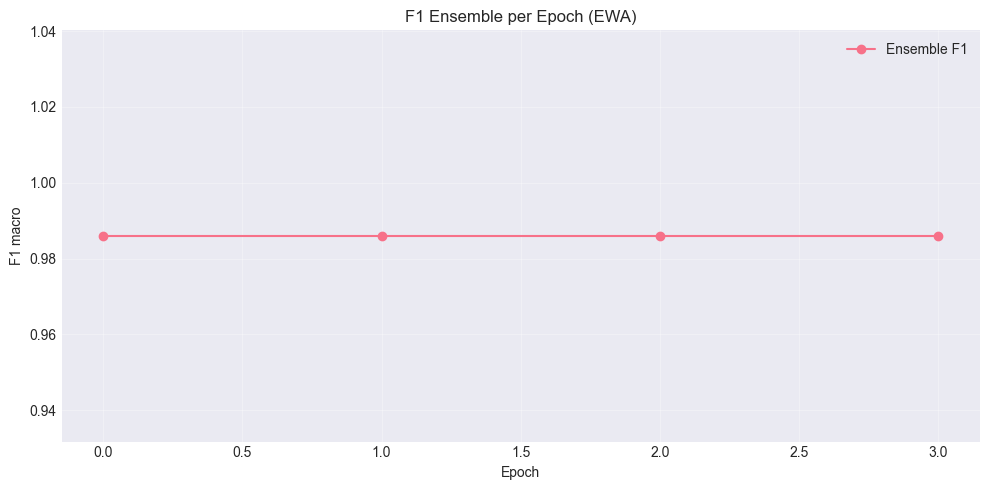

🔥 F1 ensemble finale: 0.9859661116109423


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# funzione ensemble (uguale alla tua)
def ensemble_predict(models, weights, X):
    weighted = None
    for w, m in zip(weights, models):
        probs = predict_proba_on_array(m, X)
        if weighted is None:
            weighted = w * probs
        else:
            weighted += w * probs
    preds = np.argmax(weighted, axis=1)
    return preds


# ==========================
#  CALCOLO F1 ENSEMBLE PER EPOCH
# ==========================
# trova prima la lunghezza minima delle history (alcuni modelli stop prima)
min_len = min(len(h) for h in histories)

ensemble_f1_per_epoch = []

for epoch in range(min_len):

    # lista dei modelli "tagliati" all'epoch attuale
    partial_models = []

    for model, hist in zip(models, histories):

        # clone se vuoi, ma va bene così:
        # ogni modello è già nel suo best_state
        # quindi puoi usare il modello così com'è
        partial_models.append(model)

    # ora ensemble
    preds = ensemble_predict(partial_models, weights, X_val)
    f1 = f1_score(y_val, preds, average="macro")
    ensemble_f1_per_epoch.append(f1)

# ==========================
#  PLOT
# ==========================
plt.figure(figsize=(10, 5))
plt.plot(ensemble_f1_per_epoch, marker="o", label="Ensemble F1")
plt.xlabel("Epoch")
plt.ylabel("F1 macro")
plt.title("F1 Ensemble per Epoch (EWA)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("🔥 F1 ensemble finale:", ensemble_f1_per_epoch[-1])


## 9. Evaluation

🔥 F1 ensemble (macro): 0.9859661116109423

📊 Classification Report (ENSEMBLE):

              precision    recall  f1-score   support

   high_pain     0.9868    0.9615    0.9740        78
    low_pain     0.9778    1.0000    0.9888       132
     no_pain     0.9958    0.9944    0.9951       716

    accuracy                         0.9924       926
   macro avg     0.9868    0.9853    0.9860       926
weighted avg     0.9925    0.9924    0.9924       926



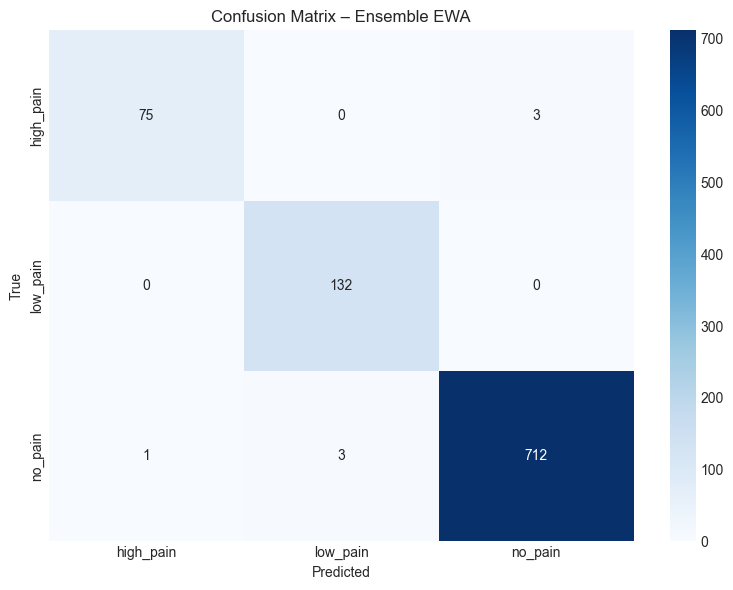

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ============================
# 1) Predizioni ensemble
# ============================
ens_preds = ensemble_predict(models, weights, X_val)

print("🔥 F1 ensemble (macro):", f1_score(y_val, ens_preds, average="macro"))
print()

# ============================
# 2) Classification report
# ============================
print('📊 Classification Report (ENSEMBLE):\n')
print(classification_report(
    y_val,
    ens_preds,
    target_names=label_encoder.classes_,
    digits=4
))

# ============================
# 3) Confusion matrix
# ============================
cm = confusion_matrix(y_val, ens_preds)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    ax=ax
)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix – Ensemble EWA")
plt.tight_layout()
plt.show()


## 10. Test Set Prediction e Submission

In [27]:
## 10. Test Set Prediction & Submission (Ensemble EWA)

print("📊 Loading test data...")
X_test = pd.read_csv('pirate_pain_test.csv')

print(f"   Shape: {X_test.shape}")
print(f"   Samples: {X_test['sample_index'].nunique()}")
print(f"   Timesteps/sample: {X_test.groupby('sample_index').size().iloc[0]}")

# ============================
# Preprocessing (identico al train)
# ============================

X_test_proc = X_test.copy()

# categorical mapping
for col, mapping in cat_map.items():
    X_test_proc[col] = X_test_proc[col].map(mapping).fillna(0).astype(int)

# time features
max_time_test = X_test_proc["time"].max()
X_test_proc["time_sin"]  = np.sin(2*np.pi*X_test_proc["time"]/max_time_test)
X_test_proc["time_cos"]  = np.cos(2*np.pi*X_test_proc["time"]/max_time_test)
X_test_proc["time_norm"] = X_test_proc["time"]/max_time_test

print("✅ Test preprocessing done")

# ============================
# Predict ensemble
# ============================

print("🔄 Predicting on test (EWA ensemble)...")

test_sample_indices = X_test["sample_index"].unique()
results = []

for sid in tqdm(test_sample_indices, desc="Predicting"):

    # create windows for this sample
    windows = create_windows(X_test_proc, sid, WINDOW_SIZE, WINDOW_STRIDE)

    if len(windows) == 0:
        # fallback: predict class 0
        results.append((sid, 0))
        continue

    X_sample = np.array(windows, dtype=np.float32)

    # scaling (identico al train)
    X_sample = scaler.transform(
        X_sample.reshape(-1, X_sample.shape[-1])
    ).reshape(X_sample.shape)

    # ============================
    # ensemble soft EWA
    # ============================
    weighted_probs = None
    for w, m in zip(weights, models):
        probs = predict_proba_on_array(m, X_sample)  # (n_windows, C)
        avg_prob = probs.mean(axis=0)

        if weighted_probs is None:
            weighted_probs = w * avg_prob
        else:
            weighted_probs += w * avg_prob

    final_class = int(np.argmax(weighted_probs))
    results.append((sid, final_class))

print("✅ Test prediction complete!")

# ============================
# Build submission
# ============================

submission = pd.DataFrame({
    "sample_index": [sid for sid, _ in results],
    "label": label_encoder.inverse_transform([cls for _, cls in results])
})

submission.to_csv("submission_ewa_pytorch.csv", index=False)

print("\n💾 Saved to submission_ewa_pytorch.csv")
print("📊 Label distribution:")
print(submission["label"].value_counts())

display(submission.head(10))


📊 Loading test data...
   Shape: (211840, 40)
   Samples: 1324
   Timesteps/sample: 160
✅ Test preprocessing done
🔄 Predicting on test (EWA ensemble)...


Predicting: 100%|██████████| 1324/1324 [01:04<00:00, 20.65it/s]

✅ Test prediction complete!

💾 Saved to submission_ewa_pytorch.csv
📊 Label distribution:
label
no_pain      1036
low_pain      186
high_pain     102
Name: count, dtype: int64


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,no_pain
3,3,no_pain
4,4,no_pain
5,5,no_pain
6,6,no_pain
7,7,no_pain
8,8,no_pain
9,9,no_pain


## 11. F1 Score Analysis e Ottimizzazione

Analizziamo come massimizzare l'F1 macro score.

🎯 F1 Score Analysis – Ensemble EWA

📊 Per-Class Metrics:

high_pain:
  Precision: 0.9868
  Recall:    0.9615
  F1 Score:  0.9740

low_pain:
  Precision: 0.9778
  Recall:    1.0000
  F1 Score:  0.9888

no_pain:
  Precision: 0.9958
  Recall:    0.9944
  F1 Score:  0.9951

🎯 Overall F1 Scores:
   F1 Macro (challenge metric): 0.9860
   F1 Weighted:                 0.9924


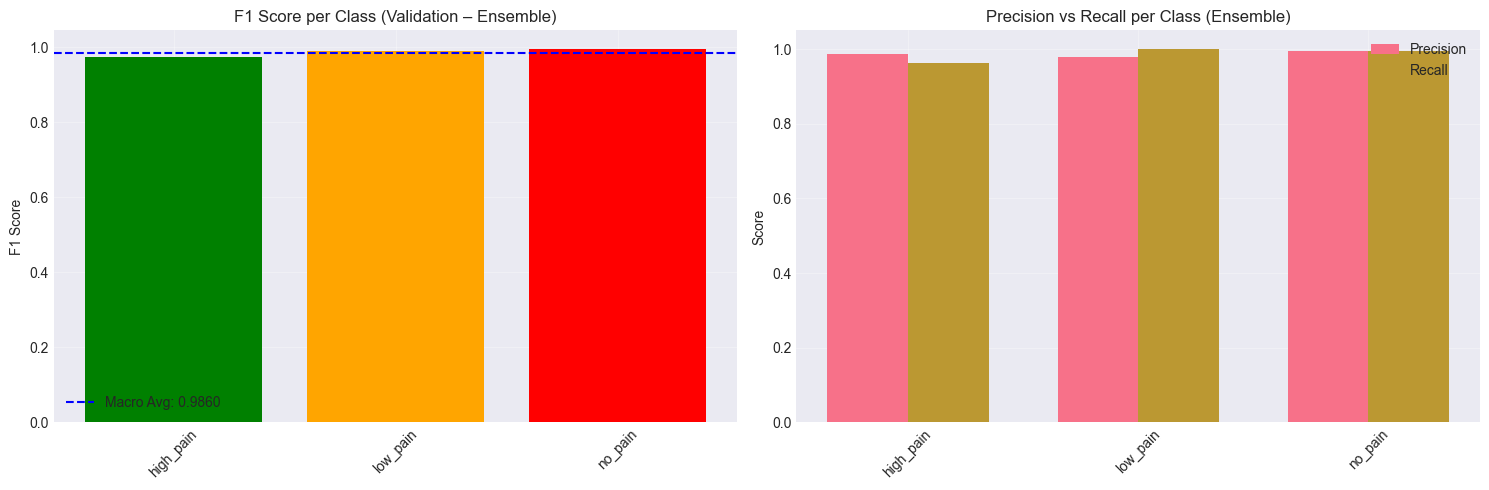

In [28]:
## 11. F1 Score Analysis e Ottimizzazione (Ensemble)

from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    classification_report
)

print("🎯 F1 Score Analysis – Ensemble EWA\n")

# ============================
# Predizioni ensemble
# ============================
ens_preds = ensemble_predict(models, weights, X_val)

# ============================
# Per-class metrics
# ============================
f1_per_class = f1_score(y_val, ens_preds, average=None)
precision_per_class = precision_score(y_val, ens_preds, average=None)
recall_per_class = recall_score(y_val, ens_preds, average=None)

print("📊 Per-Class Metrics:\n")
for i, label_name in enumerate(label_encoder.classes_):
    print(f"{label_name}:")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall:    {recall_per_class[i]:.4f}")
    print(f"  F1 Score:  {f1_per_class[i]:.4f}")
    print()

# ============================
# Overall F1
# ============================
f1_macro = f1_score(y_val, ens_preds, average="macro")
f1_weighted = f1_score(y_val, ens_preds, average="weighted")

print("🎯 Overall F1 Scores:")
print(f"   F1 Macro (challenge metric): {f1_macro:.4f}")
print(f"   F1 Weighted:                 {f1_weighted:.4f}")

# ============================
# Visualization
# ============================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ---- F1 per class ----
ax1 = axes[0]
x_pos = np.arange(len(label_encoder.classes_))
ax1.bar(x_pos, f1_per_class, color=["green", "orange", "red"])
ax1.set_xticks(x_pos)
ax1.set_xticklabels(label_encoder.classes_, rotation=45)
ax1.set_ylabel("F1 Score")
ax1.set_title("F1 Score per Class (Validation – Ensemble)")
ax1.axhline(y=f1_macro, color="blue", linestyle="--",
            label=f"Macro Avg: {f1_macro:.4f}")
ax1.legend()
ax1.grid(True, alpha=0.3)

# ---- Precision vs Recall ----
ax2 = axes[1]
width = 0.35

ax2.bar(x_pos - width/2, precision_per_class, width, label="Precision")
ax2.bar(x_pos + width/2, recall_per_class, width,   label="Recall")

ax2.set_xticks(x_pos)
ax2.set_xticklabels(label_encoder.classes_, rotation=45)
ax2.set_ylabel("Score")
ax2.set_title("Precision vs Recall per Class (Ensemble)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
